# Basic Signal Processing and Curve Fitting

R. Vasudevan
Oak Ridge National Laboratory

In this notebook we will walk thruogh basic 1D signal processing, including denoising, FFT filtering and curve fitting.

In [1]:
# Load packages necessary
import numpy as np
import matplotlib.pyplot as plt

# Generate some data


### Let's generate some data to play with. Let it be composed of sine functions of different frequencies and phases, and add some noise to make it realistic.
    

    
$y = sin(2\pi f_1 t + \phi_1) +  sin(2\pi f_2 t + \phi_2) +\epsilon$

<p>
where $\epsilon$ is some noise

</font>

In [2]:
f1 = 2.2 #frequency of wave 1
f2 = 1.6 #frequency of wave 2

phi_1 = np.pi/4 #phase of wave 1
phi_2 = np.pi/6 #phase of wave 2

t = np.linspace(0,10,500) #time vector
k = 0.20 #noise factor. Increase to make observations more noisy.


wave_1 = np.sin(2*np.pi*f1*t + phi_1) +  k * np.random.normal(size=t.size) #generate wave 1 with noise
wave_2 = np.sin(2*np.pi*f2*t + phi_2) +  k * np.random.normal(size=t.size) #generate wave 2 with noise

y = wave_1 + wave_2 #observations


# Plot the data

Text(0.5,1,'k = 0.2')

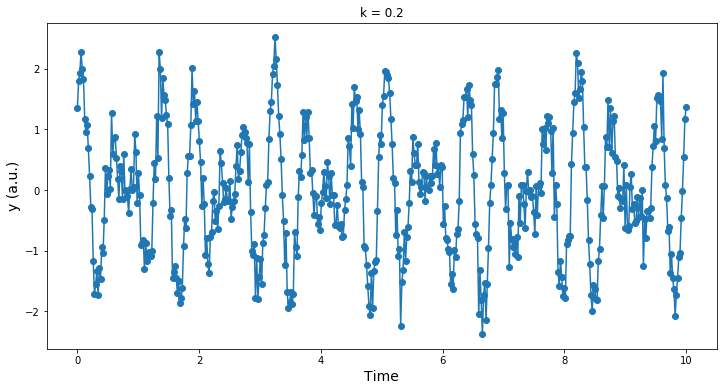

In [3]:
#Let's plot this to see what it looks like

fig, axes  = plt.subplots(figsize = (12,6))
axes.plot(t, y, marker = 'o', linestyle = '-')
axes.set_xlabel('Time', fontsize = 14)
axes.set_ylabel('y (a.u.)', fontsize = 14)
axes.set_title('k = ' + str(k))

# Let's do some filtering

Let's first do a moving window filter. Types include:
    - Median Filter
    - Savgol Filter
    - Wiener Filter

Let's see how all of these perform

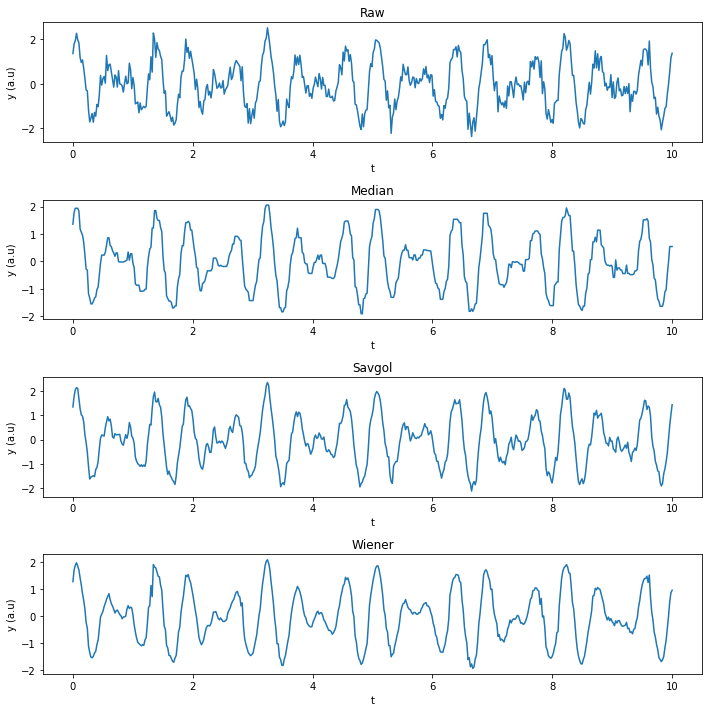

In [4]:
#Import the filters
from scipy.signal import medfilt, savgol_filter, wiener

#Filter the data
median_filtered_data = medfilt(y, kernel_size = 5) #the kernel size is the window size
savgol_filtered_data = savgol_filter(y, window_length = 5, polyorder=2) #There are more options available for this filter. Try them!
wiener_filtered_data = wiener(y, mysize = 5)


all_data = [y, median_filtered_data, savgol_filtered_data, wiener_filtered_data]
labels = ['Raw', 'Median', 'Savgol','Wiener']

#Let's see how they all performed

fig, axes = plt.subplots(nrows=4, ncols = 1, figsize = (10,10))
for ydata, label, ax in zip(all_data, labels, axes.flat):
                                       
    ax.plot(t, ydata)
    ax.set_title(label)
    ax.set_xlabel('t')
    ax.set_ylabel('y (a.u)')

fig.tight_layout()

In [5]:
#Let's see what happens if we change window sizes


# Fourier Filtering

Given this function is periodic, perhaps a moving window is not the right choice. Let's see what Fourier filtering can do for us.

Text(0.5,1,'Fourier Transform of y (amplitide)')

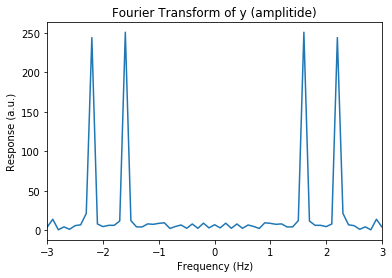

In [6]:
#let's calculate the Fourier transform

fft_y = np.fft.fft(y) #Do the Fourier transformation

#By default the transformation does not put the lower frequencies at the center. To fix this, we can use fftshift
#this will ensure that our signal has the low frequency components at the center, and the high frequencies at the edges

fft_y_shift = np.fft.fftshift(fft_y) 

'''
It is important to create the frequency vector, which requires us to know the sampling rate. 
The sampling rate is the number of points measured per second. In our case, this can be calcualted easily
by determining the number of seconds (10), and the total number of measured pixels (t.size).

'''
w_vec = np.linspace(-0.5*t.size/max(t), 0.5*t.size/max(t) - t.size/max(t)/t.size,t.size) #generate frequency vector

fig, axes = plt.subplots()
axes.plot(w_vec, np.abs(fft_y_shift))
axes.set_xlim([-3,3])
axes.set_xlabel ('Frequency (Hz)')
axes.set_ylabel ('Response (a.u.)')
axes.set_title('Fourier Transform of y (amplitide)')


In [7]:
#Find the two peaks.
#We can use the sort algorithm, which sorts data from the smallest to largest

#Get the absolute values only
abs_fft_shift = np.abs(fft_y_shift)

#Sort the data from smallest to largest. Use of argsort gives the indices, instead of the values
#This will be required for us.

sorted_maxima_ascending = np.argsort(abs_fft_shift) 

#Since we want the maximum, not the minimum, we should sort the array in descending order.
#This can easily be done by reversing the order, which is done below using numpy's indexing functionality.

sorted_maxima_descending = sorted_maxima_ascending[::-1] 


In [8]:
#Let's list the frequencies of the top ten amplitudes
w_vec[sorted_maxima_descending[:10]]

array([ -1.6,   1.6,   2.2,  -2.2,  -2.3,   2.3, -12.7,  12.7, -14.7,
        14.7])

# Reconstruct via use of the first two Fourier components

In [9]:
#let's reconstruct the signal based on the first two Fourier peaks
#for that we need the phases also. We can get this by using np.angle
phase_vals = np.angle(fft_y_shift)
phase_1 = phase_vals[[sorted_maxima_descending[0]]] #Here we take the frequency at which the maximum amplitude occurs, 
                                            #and then get the associated phase
phase_2 = phase_vals[[sorted_maxima_descending[2]]] #Same, for the second one.

y1 = np.sin(2*np.pi*t*w_vec[sorted_maxima_descending[0]] + phase_1)
y2 = np.sin(2*np.pi*t*w_vec[sorted_maxima_descending[2]] + phase_2)

y_fft_recon = y1 + y2


# Let's Plot the FFT Filtered Signal

Text(0,0.5,'y (a.u.)')

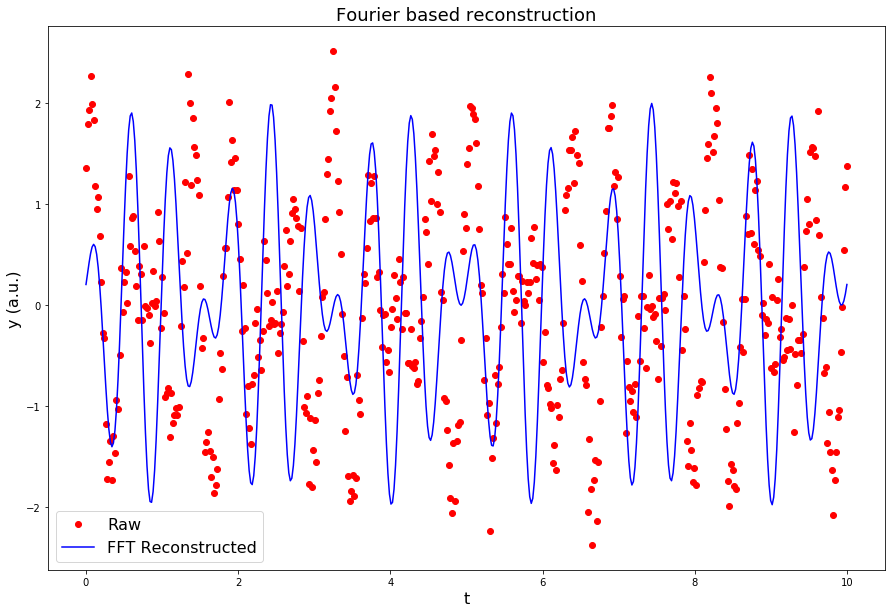

In [10]:
fig, axes = plt.subplots(figsize = (15,10))
axes.plot(t,y, 'ro', label = 'Raw')
axes.plot(t,y_fft_recon, 'b-', label = 'FFT Reconstructed')
axes.legend(loc = 'best', fontsize = 16)
axes.set_title('Fourier based reconstruction', fontsize = 18)
axes.set_xlabel('t', fontsize =16)
axes.set_ylabel('y (a.u.)', fontsize = 16)

# Alternative Method: Band-pass filtering

Instead of trying to reconstruct based on the two frequencies, we can simply apply a bandpass filter and try to reconstruct it

In [11]:
from scipy.signal import butter, lfilter, freqz

cutoff = 5.1 #cutoff frequency
sampling_rate = t.size/max(t)
nyq = 0.5 * sampling_rate #Nyquist frequency
normal_cutoff = cutoff / nyq #Normalize the cutoff frequency

#Let's create the lowpass filter
b, a = butter(3, normal_cutoff, btype='lowpass', analog=False)

#Filter the data
filtered_data = lfilter(b,a,y)

Text(0,0.5,'y (a.u.)')

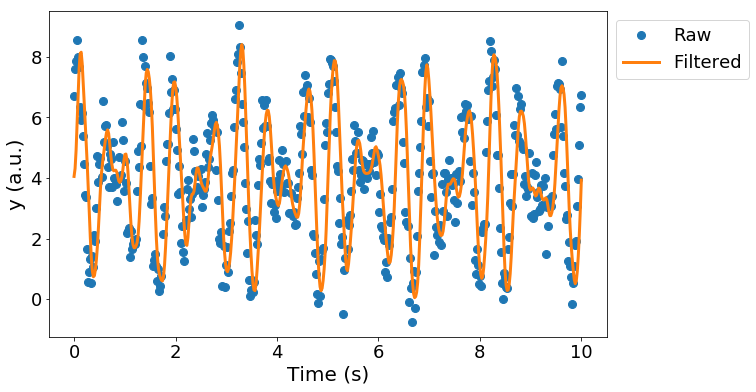

In [12]:
fig, axes = plt.subplots(figsize = (10,6))
axes.plot(t, y, label = 'Raw', marker = 'o', markersize = 8, linewidth = 0)
axes.plot(t, filtered_data, linewidth = 3, label = 'Filtered')
axes.legend(bbox_to_anchor = [1.0,1.0], fontsize = 18)
axes.set_xticklabels(ax.get_xticklabels(), fontsize = 18);
axes.set_yticklabels(ax.get_xticklabels(), fontsize = 18);
axes.set_xlabel('Time (s)', fontsize = 20)
axes.set_ylabel('y (a.u.)', fontsize = 20)

# Curve Fitting

Now suppose we want to instead fit a function to the dataset. We can utilize scipy to do this, specifically functions within scipy.optimize. We shall try to do this for the above dataset, to fit two sin functions

In [13]:
#Import the library reqired
from scipy.optimize import curve_fit

#First we need to define the fitting function.

def two_sin_funcs(t, f1, phi1, f2, phi2):
    
    y = np.sin(2*np.pi*f1*t + phi1) + np.sin(2*np.pi*f2*t + phi2)
    
    return y

lb = (0,-np.pi/2, 0, -np.pi/2) #lower bounds
ub = (1E4,np.pi/2, 1E4, np.pi/2) #upper bounds

popt, pcov = curve_fit(two_sin_funcs, t, y, p0=[1.6, 0.5, 2.0, 0.5], bounds = (lb,ub)) 

#popt and pcov return the optimum values of the parameters and the covariance matrix, respectively
#the curve fitting respects the bounds, and the initial conditions are given by p0


Take a look at the output of the curve fitting.

In [14]:
popt

array([1.59856117, 0.57370504, 1.96154421, 1.57079633])

And take a look at the covariance matrix

In [15]:
pcov

array([[ 1.24373203e-05, -3.93678974e-04,  2.86885133e-06,
        -8.87148661e-05],
       [-3.93678974e-04,  1.63863045e-02, -8.93742769e-05,
         3.09176680e-03],
       [ 2.86885133e-06, -8.93742769e-05,  1.26530164e-05,
        -3.95913931e-04],
       [-8.87148661e-05,  3.09176680e-03, -3.95913931e-04,
         1.63353688e-02]])

We usually care about the diagonal elements...

In [16]:
np.diag(pcov)

array([1.24373203e-05, 1.63863045e-02, 1.26530164e-05, 1.63353688e-02])

In [17]:
y_fit = two_sin_funcs(t, *popt) #the star just means provide these elements one at a time to the function.

Text(0.5,1,'Functional Fit')

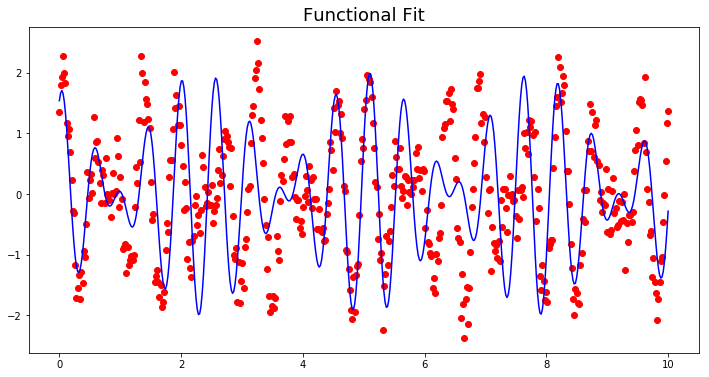

In [18]:
#Let's plot the results of the fitting

fig, axes = plt.subplots(figsize = (12,6))
axes.plot(t,y, 'ro', label = 'Raw')
axes.plot(t, y_fit, 'b-', label = 'Fitted')
axes.set_title('Functional Fit', fontsize = 18)

# Exercise

To test your knowledge, do the following exercise

1. Simulate some kind of  data. E.g., use a polynomial function
2. Try smoothing the data with a median filter
3. Fit the smoothed and unsmoothed data, and compare the results.